In [1]:
from Classess import GPT
import torch
from hellaswag import render_example, iterate_examples
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_lr = 6e-4
weight_decay = 0.1
beta1, beta2 = 0.9, 0.95

checkpoint_path = './model_fourepochs_76291_125M.pt'
train_loss_path = '../log/log_4epochs.txt'
val_loss_path = '../log/val_log_4epochs.txt'
model_from_checkpoint = GPT()

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

state_dict = checkpoint['model']
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("_orig_mod."):
        new_state_dict[k[len("_orig_mod."):]] = v 
    else:
        new_state_dict[k] = v

missing_keys, unexpected_keys = model_from_checkpoint.load_state_dict(new_state_dict, strict=False)
if missing_keys:
    print(f"Missing keys: {missing_keys}")
if unexpected_keys:
    print(f"Unexpected keys: {unexpected_keys}")
    
model_from_checkpoint = model_from_checkpoint.to(device)


optimizer = model_from_checkpoint.configure_optimizers(weight_decay, max_lr, (beta1, beta2), device)
if 'optimizer' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer'])

print(device)

num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 99, with 171,648 parameters
using fused AdamW: True
cuda


In [4]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
# print(enc.decode(model_from_checkpoint.generate(torch.tensor(enc.encode("Big")).to(device).view(1, -1), 25)[0].tolist()))
print(enc.decode(model_from_checkpoint.generate(torch.tensor(enc.encode("Hello, I'm a language model,")).to(device).view(1, -1), 15)[0].tolist()))
print(enc.decode(model_from_checkpoint.generate(torch.tensor(enc.encode("Hello, I'm a language model,")).to(device).view(1, -1), 15)[0].tolist()))
print(enc.decode(model_from_checkpoint.generate(torch.tensor(enc.encode("Hello, I'm a language model,")).to(device).view(1, -1), 15)[0].tolist()))
print(enc.decode(model_from_checkpoint.generate(torch.tensor(enc.encode("Hello, I'm a language model,")).to(device).view(1, -1), 15)[0].tolist()))
print(enc.decode(model_from_checkpoint.generate(torch.tensor(enc.encode("Hello, I'm a language model,")).to(device).view(1, -1), 15)[0].tolist()))


Hello, I'm a language model, but I'll say I actually support a few languages. I'm somewhat exhausted
Hello, I'm a language model, I've talked about it before, but now I have rid my mind to
Hello, I'm a language model, so I thought I would write a convenient sample to use more readily. This
Hello, I'm a language model, mocked first., i also exhibited my imperfect first two languages for him: Python
Hello, I'm a language model, how can we represent this role model/meaning/aspiration as an ont


In [5]:
from hellaswag import render_example, iterate_examples

def get_most_likely_row(tokens, mask, logits):
    # evaluate the autoregressive loss at all positions
    shift_logits = (logits[..., :-1, :]).contiguous()
    shift_tokens = (tokens[..., 1:]).contiguous()
    flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    flat_shift_tokens = shift_tokens.view(-1)
    shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
    shift_losses = shift_losses.view(tokens.size(0), -1)
    # now get the average loss just for the completion region (where mask == 1), in each row
    shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
    masked_shift_losses = shift_losses * shift_mask
    # sum and divide by the number of 1s in the mask
    sum_loss = masked_shift_losses.sum(dim=1)
    avg_loss = sum_loss / shift_mask.sum(dim=1)
    # now we have a loss for each of the 4 completions
    # the one with the lowest loss should be the most likely
    pred_norm = avg_loss.argmin().item()
    return pred_norm

num_correct_norm = 0
num_total = 0
for i, example in enumerate(iterate_examples("val")):
    # render the example into tokens and labels
    _, tokens, mask, label = render_example(example)
    tokens = tokens.to(device)
    mask = mask.to(device)
    # get the logits
    with torch.no_grad():
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model_from_checkpoint(tokens)
        pred_norm = get_most_likely_row(tokens, mask, logits)
    num_total += 1
    num_correct_norm += int(pred_norm == label)
    
acc_norm = num_correct_norm / num_total
print(f"HellaSwag accuracy: {num_correct_norm}/{num_total}={acc_norm:.4f}") #31.7

HellaSwag accuracy: 3319/10042=0.3305


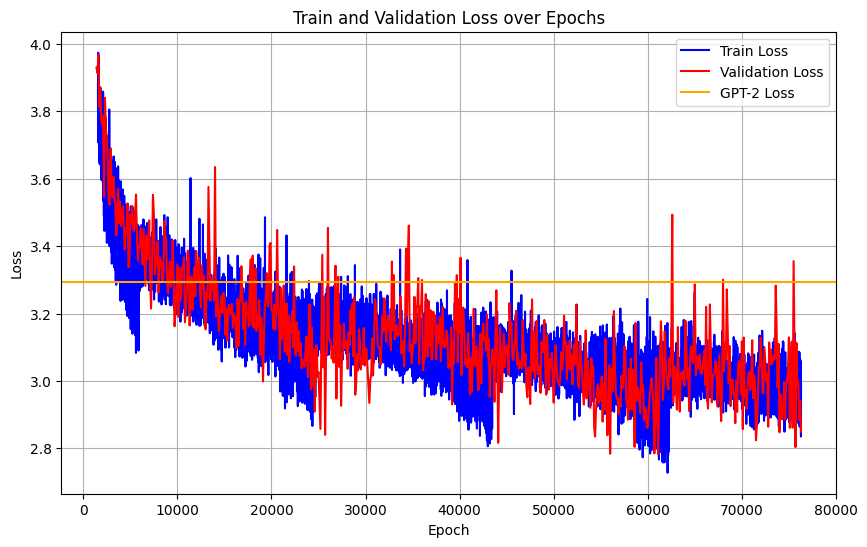

In [10]:
import matplotlib.pyplot as plt

start_graph = 0.11
def read_loss_file(file_path):
    epochs = []
    losses = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            epoch = int(parts[0].split(':')[1])
            loss = float(parts[1].split(':')[1])
            epochs.append(epoch)
            losses.append(loss)
    return epochs, losses


train_epochs, train_losses = read_loss_file(train_loss_path)
val_epochs, val_losses = read_loss_file(val_loss_path)

plt.figure(figsize=(10, 6))

plt.plot(train_epochs[int(start_graph * len(train_epochs)):], train_losses[int(start_graph * len(train_losses)):], color='b', label='Train Loss')
plt.plot(val_epochs[int(start_graph * len(val_epochs)):], val_losses[int(start_graph * len(val_losses)):], color='r', label='Validation Loss')
plt.axhline(y=3.2924, color='orange', label='GPT-2 Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.grid(True)
plt.legend()

plt.show()
